# Better mass matrices for NUTS

I love working with PyMC3 (and sometimes Stan), but one thing
that drives me nuts is the need to tinker with
parametrizations, just to make the sampler happy. Most
beginners will have used a centered parametrization
where a non-centered would have been appropriate at some point,
and might have lost days because of it. And then you have to
switch back to a centered parametrization when the
dataset calls for it. This and similar parametrization games
might be the biggest problem for the larger adaptation of
these very useful methods.

I don't think we will be able to really fix this. PyMC3 and Stan
allow you to define arbitrarily complicated models, and there
is no way that we can write a sampler that will be able to
deal with all of those. And in many cases unhappy samplers have
pointed me to improvements of my model. But I still hope that we
can improve things quite a bit. My current list of of ideas
looks something like this:

- We need better documentation about what parametrizations are,
  and why they are important.
- We need a better understanding of common reparametrizations.
  We keep pointing people to the centered vs non-centerd example,
  but this is hardly the only useful reparametrization. There is
  also the trick of multiplying a standard normal distribution
  with a Cholesky of a covariance, to generate multivariate
  normal samples. Or transformations that reign in long posterior
  tails. Or restricting the sample mean of a variable to zero. 
  Just to name a few.
- In some cases it should be possible to include them directly
  into software. Maybe there should be something like
  `pm.Horseshoe('y', parametrization='non-centered-phi')` or
  `pm.Normal('beta', sd=sd, parametrization='centered')`.
- Is it possible to choose between parametrizations
  automatically? For example, we could represent a normal
  variable as `y = sd ** w * pm.Normal('y_raw', sd=sd ** (1 - w))`.
  If we set `w = 0`, we get a non-centered parametrization,
  for `w = 1` a centered one. Could we dynamically change
  `w` during tuning?

There should still be ways left to improve the sampler itself
though. So far we have neglegted one source of information
that the sampler could use to improve tuning for mostly normal,
but correlated posteriors. If this turns out to work well in
practice it might help a lot with samping for models with large
datasets...

## An artificial example

Let's build a model with a correlated posterior that gives the
sampler some trouble. Other than the correlations, this is well
behaved:

In [1]:
import numpy as np
import pymc3 as pm
from scipy import linalg, stats, special
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import covariance

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [1466]:
N = 200

np.random.seed(42)

# Generate random eigenvectors
O = stats.ortho_group.rvs(N)

# Generate eigenvalues
eigs = np.exp(np.random.randn(N) * 2 + 1)
eigs.sort()

C = O.T @ np.diag(eigs) @ O

In [1468]:
with pm.Model() as model:
    pm.MvNormal('a', mu=np.zeros(N), cov=C, shape=N)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 2000/2000 [03:46<00:00,  7.23draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


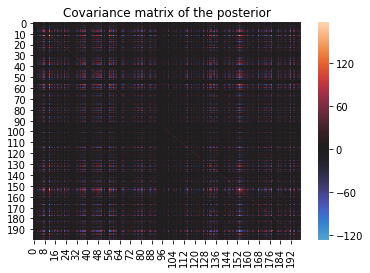

In [1557]:
sns.heatmap(C, center=0)
plt.title('Covariance matrix of the posterior');

In [1579]:
print('Mean number of leapfrog steps per sample:', np.mean(trace.tree_size))
print('Mean step size in leapfrog steps:', np.mean(trace.step_size))
print('Effective samples per second:', pm.effective_n(trace)['a'].min() / time_lw)

Mean number of leapfrog steps per sample: 453.528
Mean step size in leapfrog steps: 0.01911965419251547
Effective samples per second: 0.10127404156686214


We clearly managed to make the sampler unhappy. It is using very long trajectories (about 500 steps per sample), and consequently takes a long time per sample. And it still doesn't manage to get more than 200 effective samples.

What is going on? The covariance of the posterior (`C`) is really ill conditioned. Let's have a look at the log eigenvalues:

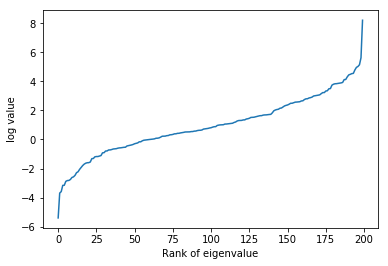

In [1554]:
plt.plot(np.log(linalg.eigvalsh(C)))
plt.xlabel('Rank of eigenvalue')
plt.ylabel('log value');

This looks really bad, the condition number is quite large:

In [1470]:
lower, *_, upper = linalg.eigvalsh(C); upper / lower

809517.4124875471

So in one direction the posterior is almost a million times wider than in another direction. The sampler will have to make quite small steps to make sure it doesn't step outside the typical set in the narrow direction. But with step sizes this small it takes a long time to traverse the posterior in the wide direction.

PyMC3 is trying to fix this by rescaling the coordinate axis, so that the diagonal of the covariance matrix contains ones. Even if it does this perfectly, this doesn't help much in this case though:

In [8]:
C_corr = C.copy()
C_corr /= np.sqrt(np.diag(C))[:, None]
C_corr /= np.sqrt(np.diag(C))[None, :]

Text(0.5,1,'The correlation matrix of the posterior')

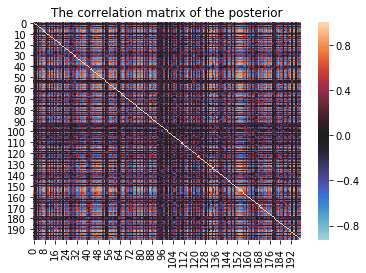

In [1556]:
sns.heatmap(C_corr, center=0)
plt.title('The correlation matrix of the posterior')

With this we get it down to a factor of 500000 instead of one million. Still quite horrible.

In [10]:
lower, *_, upper = linalg.eigvalsh(C_corr); upper / lower

541361.9082513296

We'll just extract 100 samples from that trace, and try to come up with a better approximation to the covariance.

In [1563]:
M = 100
vals = trace['a'][:M]

We need a full rank approximation, so the empirical covariance won't do. But we can use the ledoit-wolf estimator from sklearn:

In [14]:
cov_lw = covariance.ledoit_wolf(vals)[0]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(cov_lw, ax=ax0, square=True, center=0, vmax=190, vmin=-130)
ax0.set_title('Ledoit wolf estimate of covariance')
sns.heatmap(C, ax=ax1, square=True, center=0, vmax=190, vmin=-130)
ax1.set_title('True covariance');

# We sample with the new covariance matrix
with model:
    pot = pm.step_methods.hmc.quadpotential.QuadPotentialFull(cov_lw)
    step = pm.NUTS(potential=pot)
    start = time.time()
    trace_lw = pm.sample(2000, step=step)
    time_lw = time.time() - start

In [1578]:
print('Mean number of leapfrog steps per sample:', np.mean(trace_lw.tree_size))
print('Mean step size in leapfrog steps:', np.mean(trace_lw.step_size))
print('Effective samples per second:', pm.effective_n(trace_lw)['a'].min() / time_lw)

Mean number of leapfrog steps per sample: 116.528
Mean step size in leapfrog steps: 0.09293104170210881
Effective samples per second: 20.639460039503174


This is clearly better than before, but also far from good. We only get about 20 effective samples per second. We could improve this by looking at more samples, but there is a more fundamental reason why this doesn't work well as long as we have fewer samples than dimensions:

We hope that the true covariance $C$ and our Ledoit Wolf estimate $C_{lw}$ are very similar. If so, then their inverses should also be similar, but they are clearly not:

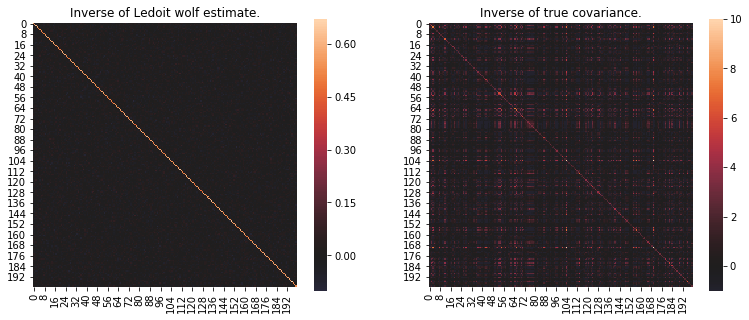

In [1581]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(linalg.inv(cov_lw), ax=ax0, square=True, center=0,)
ax0.set_title('Inverse of Ledoit wolf estimate.')
sns.heatmap(linalg.inv(C), ax=ax1, square=True, center=0, vmin=-1, vmax=10);
ax1.set_title('Inverse of true covariance.');

We can see why if we compare the eigenvalues of the true covariance and our estimate. The large eigenvalues are similar, but the small eigenvalues are not.

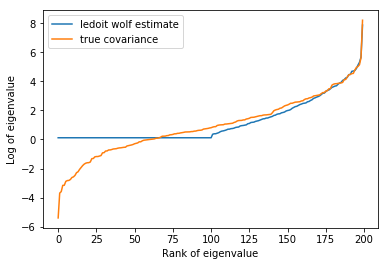

In [1583]:
plt.plot(np.log(linalg.eigvalsh(cov_lw)), label='ledoit wolf estimate')
plt.plot(np.log(linalg.eigvalsh(C)), label='true covariance')
plt.xlabel('Rank of eigenvalue')
plt.ylabel('Log of eigenvalue')
plt.legend();

## Measuring the quality of covariance approximations

Before we go on and try to fix this, it would be helpful if
we had a way to evaluate how good a covariance matrix
approximation is, without running NUTS all the time.

We can interpret a particular choice for a covariance
matrix as a basis. If we look at the eigenvalues of
the true covariance of the posterior with respect
to this basis, we can see what part of it doesn't
get explained properly. I'll call this the *residual covariance*.

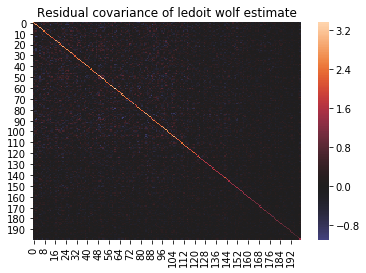

In [1591]:
def residuum(posterior_cov, approx_cov):
    S, U = linalg.eigh(approx_cov)
    transformed = U.T @ posterior_cov @ U
    transformed /= np.sqrt(S)[None, :]
    transformed /= np.sqrt(S)[:, None]
    return transformed

sns.heatmap(residuum(C, cov_lw), center=0)
plt.title('Residual covariance of ledoit wolf estimate');

We can see from the eigenvalues of this residuum that we do relatively well with the large eigenvalues, but we still have very small eigenvalues left.

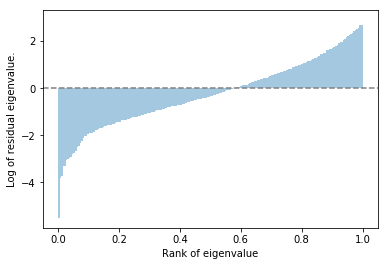

In [1595]:
plt.axhline(0, color='gray', linestyle='--')
plt.fill_between(np.linspace(0, 1, N), np.log(linalg.eigvalsh(C, cov_lw)), alpha=0.4, step='post')
plt.xlabel('Rank of eigenvalue')
plt.ylabel('Log of residual eigenvalue.');

The closer those log-eigenvalues are to zero, the better our approximation. So we use `norm(log(eigenvalues))` as measure for the quality of our covariance approximation. This actually turns out to be a metric on symmetric positive definite matrices, where $d(A, B) = d(A^{-1}, B^{-1})$. For some more information about this metric see [??]. We can compute it a bit more compactly using the generalized eigenvalue problem:

In [1596]:
def spd_dist(A, B):
    return linalg.norm(np.log(linalg.eigvalsh(A, B)))

print('Quality of Ledoit Wolf estimate:', spd_dist(C, cov_lw))

Quality of Ledoit Wolf estimate: 21.050173953577925


## The small eigenvalues

We can't do much about the problem of the small eigenvalues without
additional information. Samples from the posterior mostly tell us
about the large eigenvalues, they contain very little information
about the small ones.

But we also have access to the gradients of the logp at each of
those samples. So why is that useful?

For a standard normal distribution the gradients of the logp at $x$
are just $-x$. So their covariance is the identity matrix, just
like the covariance of the $x$ values themselves. But they behave
differently if we change the basis. The position is contravariant,
the gradient covariant. If you change from measuring the position
in feet to meter (as is only right) then the components of $x$ will decrease, but the
compontents of the gradient will increase. This different behavour
to changes of basis means that for a multivariate normal distribution,
the covariance of the gradients is the inverse of the covariance of
the distribution. But since the large eigenvalues of the inverse
correspond to the small eigenvalues of the covariance, we can get
an etimate for those from the gradients.

So let's compute the gradients for our 100 samples, and get a Ledoit Wolf estimate for the covariance of those:

In [1597]:
grads = []
func = model.logp_dlogp_function()
func.set_extra_values({})
for point in trace:
    grads.append(func(func.dict_to_array(point))[1])

grads = np.array(grads)[:M]
cov_grad = covariance.ledoit_wolf(grads)[0]

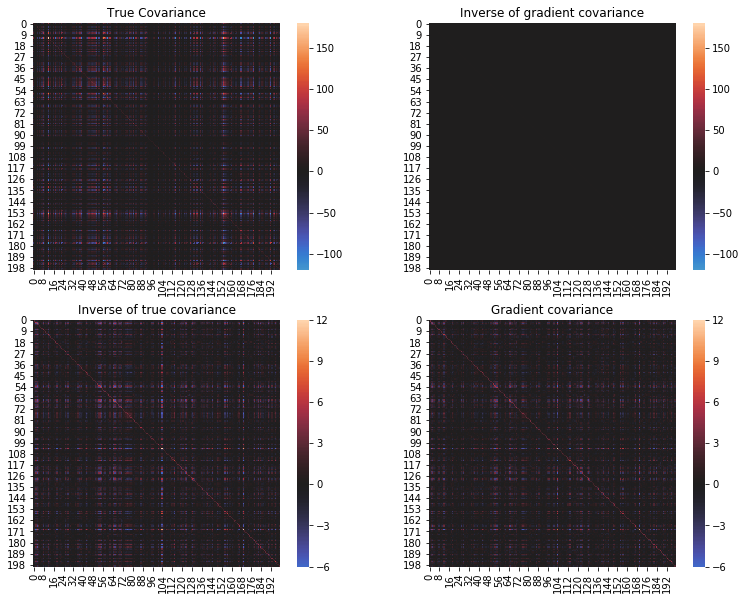

In [1599]:
fig, ((ax00, ax01), (ax10, ax11)) = plt.subplots(2, 2, figsize=(13, 10))

sns.heatmap(C, ax=ax00, square=True, center=0, vmax=180, vmin=-120);
ax00.set_title('True Covariance')
sns.heatmap(linalg.inv(cov_grad), ax=ax01, square=True, center=0, vmax=180, vmin=-120)
ax01.set_title('Inverse of gradient covariance')

sns.heatmap(linalg.inv(C), ax=ax10, square=True, center=0, vmin=-6, vmax=12)
ax10.set_title('Inverse of true covariance')
sns.heatmap(cov_grad, ax=ax11, square=True, center=0, vmin=-6, vmax=12)
ax11.set_title('Gradient covariance');

Our new covariance looks similar to the inverse of the
covariance, but the inverse of our new covariance doesn't
look similar to the covariance.

Again, we can see why if we have a look at the eigenvalues of the residuum. Our gradient based covariance estimate does ok with the small eigenvalues, but not the large ones.

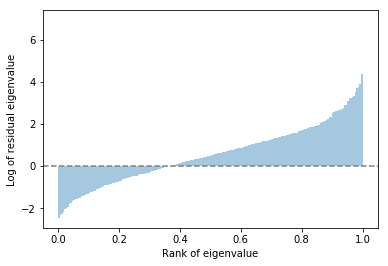

In [1600]:
plt.axhline(0, color='gray', linestyle='--')
plt.fill_between(np.linspace(0, 1, N),
                 np.log(linalg.eigvalsh(C, linalg.inv(cov_grad))),
                 alpha=0.4, step='post')
plt.xlabel('Rank of eigenvalue')
plt.ylabel('Log of residual eigenvalue');

In [1601]:
print('Quality of Ledoit Wolf estimate based on gradients:', spd_dist(linalg.inv(C), cov_grad))

Quality of Ledoit Wolf estimate based on gradients: 22.19902616170963


## Combining our estimates

So how do we combine those two estimates? 

$$
\exp(U\Sigma_1U^T + V\Sigma_2V^T)
$$

In [32]:
A_vals, A_vecs = linalg.eigh(covariance.empirical_covariance(vals))
A_vals = np.log(A_vals[-M + 1:])
A_vecs = A_vecs[:, -M + 1:]

B_vals, B_vecs = linalg.eigh(covariance.empirical_covariance(grads))
B_vals = -np.log(B_vals[-M + 1:])
B_vecs = B_vecs[:, -M + 1:]

In [33]:
out = linalg.expm(0.5 * linalg.logm(cov_lw) + 0.5 * linalg.logm(linalg.inv(cov_grad)))

In [35]:
spd_dist(C, cov_lw)

21.050173953577925

In [34]:
spd_dist(C, out)

16.988219161467864

In [65]:
_, eigs_vals, vecs_vals = linalg.svd(vals - vals.mean(0)[None, :], full_matrices=False)
_, eigs_grad, vecs_grad = linalg.svd(grads - grads.mean(0)[None, :], full_matrices=False)

# The last singular value is 0, if M < N
eigs_vals = 2 * np.log(eigs_vals[:-1]) - np.log(M)
vecs_vals = vecs_vals[:-1, :].T

eigs_grad = -2 * np.log(eigs_grad[:-1]) + np.log(M)
vecs_grad = vecs_grad[:-1, :].T

center = (eigs_vals[M//2:].mean() + eigs_grad[M//2:].mean()) / 2

eigs_vals -= center
eigs_grad -= center

weight = stats.beta(0.5, 0.5).cdf(np.linspace(0, 1, N))
weight = weight[:M - 1]

A = (vecs_vals * eigs_vals * (1 - weight)) @ vecs_vals.T
B = (vecs_grad * eigs_grad * (1 - weight)) @ vecs_grad.T
out2 = np.exp(center) * linalg.expm(A + B)

In [99]:
_, eigs_vals, vecs_vals = linalg.svd(vals - vals.mean(0)[None, :], full_matrices=False)
_, eigs_grad, vecs_grad = linalg.svd(grads - grads.mean(0)[None, :], full_matrices=False)

# The last singular value is 0, if M < N
eigs_vals = 2 * np.log(eigs_vals[:-1]) - np.log(M)
vecs_vals = vecs_vals[:-1, :].T

eigs_grad = -2 * np.log(eigs_grad[:-1]) + np.log(M)
vecs_grad = vecs_grad[:-1, :].T

center = (eigs_vals[M//2:].mean() + eigs_grad[M//2:].mean()) / 2

eigs_vals -= center
eigs_grad -= center

weight = stats.beta(0.5, 0.5).cdf(np.linspace(0, 1, N))
weight = weight[:M - 1]

A = (vecs_vals * eigs_vals * (1 - weight)) @ vecs_vals.T
B = (vecs_grad * eigs_grad * (1 - weight)) @ vecs_grad.T
out3 = linalg.expm(A + B + center * np.eye(N))

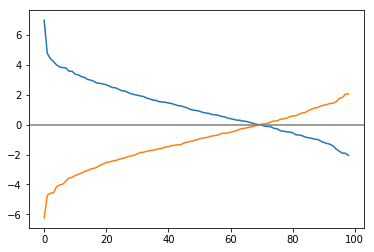

In [66]:
plt.plot(eigs_vals)
plt.plot(eigs_grad)
plt.axhline(0, color='gray')

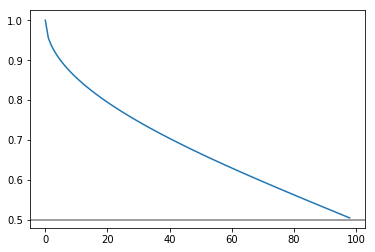

In [67]:
plt.plot(1 - weight)
plt.axhline(0.5, color='gray')

In [68]:
spd_dist(C, out2)

16.94073350840443

In [69]:
spd_dist(C, out)

16.988219161467864

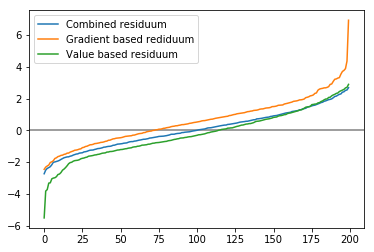

In [1542]:
plt.axhline(0, color='gray')
plt.plot(np.log(linalg.eigvalsh(residuum(C, out2))), label='Combined residuum')
plt.plot(np.log(linalg.eigvalsh(residuum(C, linalg.inv(cov_grad)))), label='Gradient based rediduum')
plt.plot(np.log(linalg.eigvalsh(residuum(C, cov_lw))), label='Value based residuum')
plt.legend();

In [73]:
with model:
    pot = pm.step_methods.hmc.quadpotential.QuadPotentialFull(cov_lw)
    step = pm.NUTS(potential=pot)
    start = time.time()
    trace_lw = pm.sample(5000, step=step, tune=1000, chains=4, cores=2)
    time_lw = time.time() - start
    
with model:
    pot = pm.step_methods.hmc.quadpotential.QuadPotentialFull(out2)
    step = pm.NUTS(potential=pot)
    start = time.time()
    trace_combined = pm.sample(5000, step=step, tune=1000, chains=4, cores=2)
    time_combined = time.time() - start

Multiprocess sampling (4 chains in 2 jobs)
NUTS: [a]
Sampling 4 chains: 100%|██████████| 24000/24000 [14:20<00:00, 27.89draws/s]
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [a]
Sampling 4 chains: 100%|██████████| 24000/24000 [06:36<00:00, 60.60draws/s]


In [103]:
neff = pm.effective_n(trace_lw)['a'].min()
neff, neff / time_lw

(17779.36715212998, 20.639460039503174)

In [104]:
neff = pm.effective_n(trace_combined)['a'].min()
neff, neff / time_combined

(15616.22035894865, 39.343255938956815)

In [942]:
linalg.blas.get_blas_funcs('gemv', arrays=[cov.vals_vecs, x])

<fortran object>

In [1452]:
def add_ADATv(A, v, out, diag=None, beta=0., work=None):
    """Run out = beta * out + A @ np.diag(D) @ A.T @ v"""
    if work is None:
        work = np.empty(A.shape[1])
    linalg.blas.dgemv(1., A, v, y=work, trans=1, beta=0., overwrite_y=True)
    if diag is not None:
        work *= diag
    linalg.blas.dgemv(1., A, work, y=out, beta=beta, overwrite_y=True)


class Covariance:
    def __init__(self, n_dim, n_svd, n_approx, values, grads, diag=None):
        assert n_svd <= len(values)
        assert values.shape == grads.shape

        self.values = values - values.mean(0)
        self.grads = grads - grads.mean(0)
        
        val_variance = self.values.var(0)
        grd_variance = self.grads.var(0)
        if diag == 'mean':
            self.diag = np.sqrt(val_variance/grd_variance)
        elif diag == 'values':
            self.diag = np.sqrt(val_variance)
        else:
            self.diag = raise ValueError()
        self.invsqrtdiag = 1/np.sqrt(self.diag)
        self.values /= self.diag[None, :]
        self.grads *= self.diag[None, :]
        
        _, svdvals, vecs = linalg.svd(self.values, full_matrices=False)
        self.vals_eigs = 2 * np.log(svdvals[:n_svd]) - np.log(len(values))
        self.vals_vecs = vecs.T[:, :n_svd].copy()
        
        _, svdvals, vecs = linalg.svd(self.grads, full_matrices=False)
        self.grad_eigs = -2 * np.log(svdvals[:n_svd]) + np.log(len(grads))
        self.grad_vecs = vecs.T[:, :n_svd].copy()
        
        self.n_dim = N
        self.n_svd = n_svd
        self.n_approx = n_approx
        
        if n_svd < n_dim // 3:
            center_slice = slice(n_svd // 3, None)
        else:
            center_slice = slice(2*n_svd // 3, (2 * n_dim) // 3)
        
        self.center = 0.5 * (
            self.grad_eigs[center_slice].mean()
            + self.vals_eigs[center_slice].mean())
        
        self.vals_eigs -= self.center
        self.grad_eigs -= self.center
        
        weight = stats.beta(0.5, 0.5).cdf(np.linspace(0, 1, N))
        self.weight = 1 - weight[:n_svd]
        
        self._make_operators(n_approx)
        
    def to_dense(self):
        vecs, eigs = self.vals_vecs, self.vals_eigs
        A = (vecs * eigs * self.weight) @ vecs.T
        
        vecs, eigs = self.grad_vecs, self.grad_eigs
        B = (vecs * eigs * self.weight) @ vecs.T
        
        corr = np.exp(self.center) * linalg.expm(A + B)
        corr *= self.diag[:, None]
        corr *= self.diag[None, :]
        return corr
    
    def invsqrt_to_dense(self):
        # TODO this is wrong
        vecs, eigs = self.vals_vecs, self.vals_eigs
        A = (vecs * eigs * self.weight) @ vecs.T
        
        vecs, eigs = self.grad_vecs, self.grad_eigs
        B = (vecs * eigs * self.weight) @ vecs.T
        
        corr = np.exp(-0.5*self.center) * linalg.expm(-0.5*(A + B))
        corr *= self.invsqrtdiag[:, None]
        corr *= self.invsqrtdiag[None, :]
        return corr

    def matmul(self, x, out=None):
        if out is None:
            out = np.empty_like(x)
        
        self._matmul(x * self.diag, out)
        out *= self.diag
        return out
    
    def invsqrtmul(self, x, out=None):
        if out is None:
            out = np.empty_like(x)
        self._matmul_invsqrt(x, out)
        #out *= self.invsqrtdiag
        return out / self.diag

    def _make_operators(self, n_eigs, exponent=1):
        vecs1, eigs1 = self.vals_vecs, self.vals_eigs
        vecs2, eigs2 = self.grad_vecs, self.grad_eigs
        vecs1 = np.ascontiguousarray(vecs1)
        vecs2 = np.ascontiguousarray(vecs2)
        
        def upper_matmul(x):
            out = np.empty_like(x)
            work = np.empty(len(eigs1))
            add_ADATv(vecs1, x, out, diag=eigs1 * self.weight, beta=0.0, work=work)
            add_ADATv(vecs2, x, out, diag=eigs2 * self.weight, beta=1.0, work=work)
            return out

        upper = slinalg.LinearOperator((self.n_dim, self.n_dim), upper_matmul)
        eigs, vecs = slinalg.eigsh(upper, k=n_eigs)
        eigs_exp = np.exp(eigs)
        eigs_invsqrtexp = np.exp(-0.5*eigs)

        def matmul_exp(x, out):
            work = np.empty(len(eigs))
            add_ADATv(vecs, x, out, diag=None, beta=0.0, work=work)
            add_ADATv(vecs, x, out, diag=eigs_exp, beta=-1.0, work=work)
            out += x
            out *= np.exp(self.center)

        def matmul_invsqrtexp(x, out):
            work = np.empty(len(eigs))
            add_ADATv(vecs, x, out, diag=None, beta=0.0, work=work)
            add_ADATv(vecs, x, out, diag=eigs_invsqrtexp, beta=-1.0, work=work)
            out += x
            out *= np.exp(-0.5*self.center)
        
        self._matmul = matmul_exp
        self._matmul_invsqrt = matmul_invsqrtexp

In [ ]:
exp(USU^T) = U exp(S) U.T
U exp(S) U.T + (I - UU.T)

In [ ]:
U_1S U_1 ^T + U_2 * diag(0) U_2.T

In [ ]:
U_[:k] @ diag(S[:k]) @ U_[:k].T + U[k:] @ diag(S[k:]) + U[k:].T

In [ ]:
U@U.T = I = U_[:k] @ U_[:k].T + U_[k:] @ U_[k:].T

In [ ]:
_, eigs_vals, vecs_vals = linalg.svd(vals - vals.mean(0)[None, :], full_matrices=False)
_, eigs_grad, vecs_grad = linalg.svd(grads - grads.mean(0)[None, :], full_matrices=False)

# The last singular value is 0, if M < N
eigs_vals = 2 * np.log(eigs_vals[:-1]) - np.log(M)
vecs_vals = vecs_vals[:-1, :].T

eigs_grad = -2 * np.log(eigs_grad[:-1]) + np.log(M)
vecs_grad = vecs_grad[:-1, :].T

center = (eigs_vals[M//2:].mean() + eigs_grad[M//2:].mean()) / 2

eigs_vals -= center
eigs_grad -= center

weight = stats.beta(0.5, 0.5).cdf(np.linspace(0, 1, N))
weight = weight[:M - 1]

A = (vecs_vals * eigs_vals * (1 - weight)) @ vecs_vals.T
B = (vecs_grad * eigs_grad * (1 - weight)) @ vecs_grad.T
out3 = linalg.expm(A + B + center * np.eye(N))

$$
\exp(U\Sigma U^T) = U\exp(\Sigma)U^T + (I - UU^T)
$$

In [79]:
def ledoit_wolf(vals, inv_basis_cov):
    eigvals, eigvecs = linalg.eigh(inv_basis_cov)

    basis = eigvecs / np.sqrt(eigvals)[None, :]
    basis_inv = (eigvecs * np.sqrt(eigvals)[None, :]).T

    vals_trafo = (basis_inv @ vals.T).T
    cov_trafo = covariance.ledoit_wolf(vals_trafo)[0]
    cov = basis @ cov_trafo @ basis.T

    return cov

In [80]:
def spd_mean(a, inv_b):
    return linalg.expm(0.5 * linalg.logm(a) + 0.5 * linalg.logm(linalg.inv(inv_b)))

In [81]:
cov0 = np.eye(N)
cov1_a = ledoit_wolf(vals, cov0)
cov1_b = ledoit_wolf(grads, cov0)

cov2_a = ledoit_wolf(vals, cov1_b)
cov2_b = ledoit_wolf(grads, cov1_a)

cov3_a = ledoit_wolf(vals, cov2_b)
cov3_b = ledoit_wolf(grads, cov2_a)

cov4_a = ledoit_wolf(vals, cov3_b)
cov4_b = ledoit_wolf(grads, cov3_a)

cov5_a = ledoit_wolf(vals, cov4_b)
cov5_b = ledoit_wolf(grads, cov4_a)

cov6_a = ledoit_wolf(vals, cov5_b)
cov6_b = ledoit_wolf(grads, cov5_a)

cov6_a = ledoit_wolf(vals, cov5_b)
cov6_b = ledoit_wolf(grads, cov5_a)
cov6 = spd_mean(cov6_a, cov6_b)

$$
C_t = \exp(t\log(\mu_1 U\Sigma U^T + \lambda_1 I) + t\log(\mu_2 V\Omega V^T+ \lambda_2 I))
$$

für $\Sigma, \Omega \in R^{n\times k}, \Sigma\Sigma^T = \Omega\Omega^T = I \in R^{k\times k}$, $k \ll n$.

We only need products $C_{\frac12}v$ and $C_{-\frac14}v$. For that we need to evalate

$$
\log(U\Sigma U^T + I)v
$$

The eigenvalues are easy: $\log(1 + \sigma_i)$

$$
Av = λv\\
(A - λI)v = 0\\
v = -λ(I - λ^{-1}A)^{-1} \\
v = -λ(I - λ^{-1}(U\Sigma U^T + I))^{-1} \\

$$

## Implement this for PyMC3

As a last step, I 

In [1448]:
class QuadPotentialLowRank(object):
    def __init__(self, ndim):
        self._cov = None
        self._iter = 0
        self._ndim = ndim
        
        self._grad_store = []
        self._sample_store = []
        self.dtype = 'float64'

    def velocity(self, x, out=None):
        if self._cov is None:
            if out is None:
                out = np.empty_like(x)
            out[:] = x
            return out

        return self._cov.matmul(x, out=out)

    def energy(self, x, velocity=None):
        if velocity is None:
            velocity = self.velocity(x)
        return 0.5 * x.dot(velocity)

    def random(self):
        rand = np.random.randn(self._ndim)
        if self._cov is None:
            return rand
        return self._cov.invsqrtmul(rand)

    def velocity_energy(self, x, v_out):
        self.velocity(x, out=v_out)
        return 0.5 * np.dot(x, v_out)

    def update(self, sample, grad, tune):
        self._iter += 1
        if not tune:
            return
        
        if self._iter < 50:
            return

        renew_iters = [90, 160, 340, 550, 800]
        if self._iter not in renew_iters:
            self._grad_store.append(grad.copy())
            self._sample_store.append(sample.copy())
            return
        
        n_samples = len(self._grad_store)
        samples = np.array(self._sample_store)
        grads = np.array(self._grad_store)
        self._sample_store.clear()
        self._grad_store.clear()
        self._cov = Covariance(self._ndim, n_samples - 5, 128, samples, grads)

In [126]:
class QuadPotentialLW(object):
    def __init__(self, ndim):
        self._chol = np.eye(ndim)
        self._cov = np.eye(ndim)
        self._iter = 0
        self._ndim = ndim
        
        self._grad_store = []
        self._sample_store = []
        self.dtype = 'float64'

    def velocity(self, x, out=None):
        return np.dot(self._cov, x, out=out)

    def energy(self, x, velocity=None):
        if velocity is None:
            velocity = self.velocity(x)
        return 0.5 * x.dot(velocity)

    def random(self):
        rand = np.random.randn(self._ndim)
        return linalg.solve_triangular(self._chol.T, rand)

    def velocity_energy(self, x, v_out):
        self.velocity(x, out=v_out)
        return 0.5 * np.dot(x, v_out)

    def update(self, sample, grad, tune):
        self._iter += 1
        if not tune:
            return
        
        if self._iter < 50:
            return

        renew_iters = [90, 160, 340, 550, 800]
        if self._iter not in renew_iters:
            self._sample_store.append(sample.copy())
            return
        
        vals = np.array(self._sample_store)
        self._sample_store.clear()
        
        self._cov = covariance.ledoit_wolf(vals)[0]
        self._chol = linalg.cholesky(self._cov, lower=True)

In [127]:
class QuadPotentialGrad(object):
    def __init__(self, ndim):
        self._cov = np.eye(ndim)
        self._invsqrt = np.eye(ndim)
        self._iter = 0
        self._ndim = ndim
        
        self._grad_store = []
        self._sample_store = []
        self.dtype = 'float64'

    def velocity(self, x, out=None):
        return np.dot(self._cov, x, out=out)

    def energy(self, x, velocity=None):
        if velocity is None:
            velocity = self.velocity(x)
        return 0.5 * x.dot(velocity)

    def random(self):
        rand = np.random.randn(self._ndim)
        return self._invsqrt @ rand

    def velocity_energy(self, x, v_out):
        self.velocity(x, out=v_out)
        return 0.5 * np.dot(x, v_out)

    def update(self, sample, grad, tune):
        self._iter += 1
        if not tune:
            return
        
        if self._iter < 50:
            return

        renew_iters = [90, 160, 340, 550, 800]
        if self._iter not in renew_iters:
            self._grad_store.append(grad.copy())
            self._sample_store.append(sample.copy())
            return
                
        vals = np.array(self._sample_store)
        grads = np.array(self._grad_store)
        self._sample_store.clear()
        self._grad_store.clear()
        
        _, eigs_vals, vecs_vals = linalg.svd(vals - vals.mean(0)[None, :], full_matrices=False)
        _, eigs_grad, vecs_grad = linalg.svd(grads - grads.mean(0)[None, :], full_matrices=False)

        M = vals.shape[0]
        subset = slice(None, None) if M >= N else slice(None, -5)
        
        # The last singular value is 0, if M < N
        eigs_vals = 2 * np.log(eigs_vals[subset]) - np.log(M)
        vecs_vals = vecs_vals[subset, :].T

        eigs_grad = -2 * np.log(eigs_grad[subset]) + np.log(M)
        vecs_grad = vecs_grad[subset, :].T

        center_slice = slice(None, M//2) if M < N // 3 else slice(N//3, 2*N//3)
        center = (eigs_vals[center_slice].mean() + eigs_grad[center_slice].mean()) / 2

        eigs_vals -= center
        eigs_grad -= center

        weight = stats.beta(0.5, 0.5).cdf(np.linspace(0, 1, N))
        weight = weight[:len(eigs_vals)]

        A = (vecs_vals * eigs_vals * (1 - weight)) @ vecs_vals.T
        B = (vecs_grad * eigs_grad * (1 - weight)) @ vecs_grad.T

        self._cov = np.exp(center) * linalg.expm(A + B)
        self._invsqrt = np.exp(-center/2) * linalg.expm(-0.5*(A + B))

In [1461]:
N = 2000

np.random.seed(42)

# Generate random eigenvectors
O = stats.ortho_group.rvs(N)

# Generate eigenvalues
eigs = np.exp(np.random.randn(N) * 3 + 1)
eigs.sort()

C = O.T @ np.diag(eigs) @ O

In [1462]:
def cond(C):
    lower, *_, upper = linalg.eigvalsh(C)
    return np.log(upper/lower)

In [1463]:
cond(C)

19.159732575127993

In [1464]:
with pm.Model() as model:
    pm.MvNormal('a', mu=np.zeros(N), cov=C, shape=N)

In [ ]:
beta = np.random.randn(10000)
tau = 1e-5

In [ ]:
class QuadPotentialGrad(object):
    def __init__(self, ndim):
        self._cov = np.eye(ndim)
        self._invsqrt = np.eye(ndim)
        self._iter = 0
        self._ndim = ndim
        
        self._grad_store = []
        self._sample_store = []
        self.dtype = 'float64'

    def velocity(self, x, out=None):
        return np.dot(self._cov, x, out=out)

    def energy(self, x, velocity=None):
        if velocity is None:
            velocity = self.velocity(x)
        return 0.5 * x.dot(velocity)

    def random(self):
        rand = np.random.randn(self._ndim)
        return self._invsqrt @ rand

    def velocity_energy(self, x, v_out):
        self.velocity(x, out=v_out)
        return 0.5 * np.dot(x, v_out)

    def update(self, sample, grad, tune):
        self._iter += 1
        if not tune:
            return
        
        if self._iter < 50:
            return

        renew_iters = [90, 160, 340, 550, 800]
        if self._iter not in renew_iters:
            self._grad_store.append(grad.copy())
            self._sample_store.append(sample.copy())
            return
                
        vals = np.array(self._sample_store)
        grads = np.array(self._grad_store)
        self._sample_store.clear()
        self._grad_store.clear()
        
        _, eigs_vals, vecs_vals = linalg.svd(vals - vals.mean(0)[None, :], full_matrices=False)
        _, eigs_grad, vecs_grad = linalg.svd(grads - grads.mean(0)[None, :], full_matrices=False)

        M = vals.shape[0]
        subset = slice(None, None) if M >= N else slice(None, -5)
        
        # The last singular value is 0, if M < N
        eigs_vals = 2 * np.log(eigs_vals[subset]) - np.log(M)
        vecs_vals = vecs_vals[subset, :].T

        eigs_grad = -2 * np.log(eigs_grad[subset]) + np.log(M)
        vecs_grad = vecs_grad[subset, :].T

        center_slice = slice(None, M//2) if M < N // 3 else slice(N//3, 2*N//3)
        center = (eigs_vals[center_slice].mean() + eigs_grad[center_slice].mean()) / 2

        eigs_vals -= center
        eigs_grad -= center

        weight = stats.beta(0.5, 0.5).cdf(np.linspace(0, 1, N))
        weight = weight[:len(eigs_vals)]

        A = (vecs_vals * eigs_vals * (1 - weight)) @ vecs_vals.T
        B = (vecs_grad * eigs_grad * (1 - weight)) @ vecs_grad.T

        self._cov = np.exp(center) * linalg.expm(A + B)
        self._invsqrt = np.exp(-center/2) * linalg.expm(-0.5*(A + B))


with model:
    pot = QuadPotentialGrad(model.ndim)
    step = pm.NUTS(potential=pot)
    trace = pm.sample(1000, step=step, tune=1000, chains=2)

In [1465]:
with model:
    pot = QuadPotentialLowRank(N)
    step = pm.NUTS(potential=pot)
    start = time.time()
    trace4 = pm.sample(1000, step=step, tune=1000, chains=2)
    time4 = time.time() - start

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains:   0%|          | 6/4000 [00:13<3:03:27,  2.76s/draws]


ValueError: Not enough samples to build a trace.

In [1449]:
with model:
    pot = QuadPotentialLowRank(N)
    step = pm.NUTS(potential=pot)
    start = time.time()
    trace4 = pm.sample(1000, step=step, tune=1000, chains=2)
    time4 = time.time() - start

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 4000/4000 [24:32<00:00,  2.24draws/s]


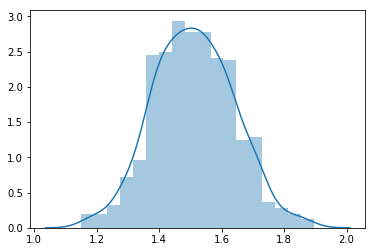

In [1459]:
sns.distplot(pm.effective_n(trace4)['a'] / time4)

In [118]:
with model:
    trace_diag = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 2000/2000 [27:57<00:00,  1.08draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [121]:
pm.effective_n(trace_diag)['a'].min()

6.832479151337405

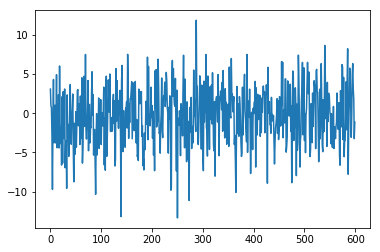

In [124]:
plt.plot(trace_diag['a'].mean(0))

In [128]:
with model:
    pot = QuadPotentialLW(N)
    step = pm.NUTS(potential=pot)
    start = time.time()
    trace4 = pm.sample(1000, step=step, tune=1000, chains=2)
    time4 = time.time() - start

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 4000/4000 [1:26:45<00:00,  2.22s/draws]


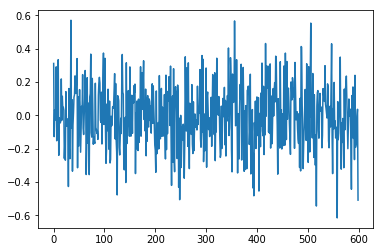

In [132]:
plt.plot(trace4['a'].mean(0))

In [129]:
with model:
    pot = QuadPotentialGrad(N)
    step = pm.NUTS(potential=pot)
    start = time.time()
    trace5 = pm.sample(1000, step=step, tune=1000, chains=2)
    time5 = time.time() - start

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 4000/4000 [14:13<00:00,  5.38draws/s]


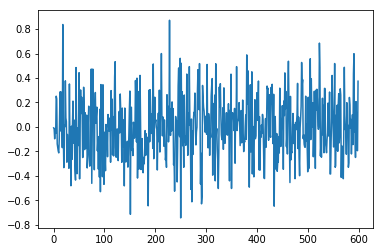

In [133]:
plt.plot(trace5['a'].mean(0))

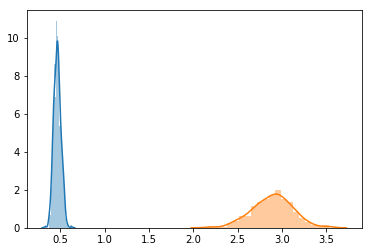

In [130]:
sns.distplot(pm.effective_n(trace4)['a'] / time4)
sns.distplot(pm.effective_n(trace5)['a'] / time5)

In [137]:
pm.effective_n(trace4)['a'].min()

1714.5617657959563

In [138]:
pm.effective_n(trace5)['a'].min()

1852.6273314872817